## France's high voltage network

Enedis (Electricity of France) recently (2018/05/16) released their networks as open geographical data. Let us try to load these data, plot and analyze them. We focus here on the high-voltage network: "lignes HTA" (the low-voltage network has also been made available as "lignes BT").

The network "lignes HTA" can be downloaded from the Enedis [data portal](https://data.enedis.fr/explore/dataset/reseau-hta/export/). Here we chose the GeoJSON file for the geographical data: reseau-hta.geojson (276.8 MB).

### Imports

In [1]:
%matplotlib inline
import geopandas as gpd  # 0.3.0
from shapely.geometry import LineString  # 1.6.4
from shapely.geometry import MultiLineString

### Load the data

It is also possible to download the data as a CSV file. The loading part with Pandas is really faster, however one has then to convert the geometry from a text format to a [shapely](https://shapely.readthedocs.io/en/latest/) geometric object.

In [2]:
%time hta = gpd.read_file('reseau-hta.geojson')

CPU times: user 51.8 s, sys: 1.74 s, total: 53.6 s
Wall time: 53.5 s


### Inspect the data

In [3]:
hta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1102066 entries, 0 to 1102065
Data columns (total 1 columns):
geometry    1102066 non-null object
dtypes: object(1)
memory usage: 8.4+ MB


In [4]:
hta.head(2)

,geometry
0,LINESTRING (0.275708182098627 47.1093150681570...
1,LINESTRING (0.495070935821371 46.9768407284384...


In [5]:
hta.crs

{'init': 'epsg:4326'}

So we have a geodataframe with a single column of 1102066 geometric entities. Note that GeoPandas took care of the coordinate reference system and reprojected the data to WGS 84 (World Geodetic System, EPSG4326). The original data was set in [RGF93](http://spatialreference.org/ref/epsg/rgf93-lambert-93/). Now let us look as the different geometry types:

In [6]:
hta['geom_type'] = hta.geometry.geom_type
hta.geom_type.value_counts()

LineString         1088976
MultiLineString      13090
dtype: int64

So we have either `LineString` or `MultiLineString` objects. Let us plot all theses lines.

### Sketch the data

CPU times: user 32.7 s, sys: 588 ms, total: 33.3 s
Wall time: 32.6 s


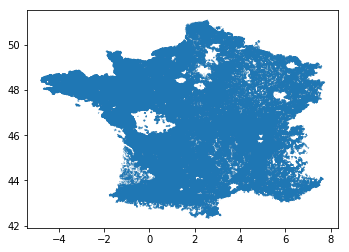

In [7]:
%time hta.plot()

It seems that some parts of France do not have electricty yet :) Or they are managed by other companies (Enedis manages the public electricity distribution network for 95% of continental France).

### Compute network's length

In the EPSG4326 projection, coordinates correspond to angles: longitude and latitude. Thus the `LineString` length is not goint to be helpful. Let us start by changing the CRS to a more appropriate one (EPSG:2154, RGF93 / Lambert-93) based on metric system:

In [8]:
%time hta.to_crs(epsg=2154, inplace=True)

CPU times: user 36.8 s, sys: 324 ms, total: 37.1 s
Wall time: 37.1 s


In [9]:
%time hta['length'] = hta.geometry.length

CPU times: user 2.27 s, sys: 40 µs, total: 2.27 s
Wall time: 2.26 s


In [10]:
hta.head(2)

,geometry,geom_type,length
0,LINESTRING (493450.4983000009 6671236.06979999...,LineString,316.533531
1,LINESTRING (509609.5552000029 6655978.72149999...,LineString,7.437865


In [11]:
hta.length.sum()

327098209.6888636

This means that we have 327098 km of high-voltage network here!